# Reproducing Villena-Gonzalez CDA Study (2019) - Averaging
1. Per Subject Averaging Left vs Right Channels instead of avering CDA
2. Grand Average, per subject ponderation: 1/nb_subjects or nb_trials_per_subj/total_trials

## Notes

In [1]:
import numpy as np
import glob
import pickle

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_bdf

import sys
sys.path.append('/Users/nick/Documents/PhD/CLCT/reprod/studies/Villena-Gonzalez-2019/')
from events import get_specific_events, get_epochs, get_CDA, prep_report, fill_report, get_report, checksum
 
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Prep Data

In [2]:
#==================================================================
# General Variables
#==================================================================
## Organize Triggers
triggers = dict();

# --------------------------
triggers['1'] = [10,11,12,13] 
triggers['2'] = [20,21,22,23]
triggers['4'] = [40,41,42,43]

triggers['left'] = [11,12,21,22,41,42]
triggers['right'] = [10,13,20,23,40,43]

triggers['good'] = [60]
triggers['bad'] = [61]

# Labels
conds = ['1', '2', '4']
sides = ['left', 'right']
perfs = ['good', 'bad']

# CDA Channels
chan_right = ['TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2']
chan_left =  ['TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1']

# Epoch information
epoch_length = 1.2
epoch_tmin = -0.2
baseline_corr = (-0.2, 0)

# CDA main variable!
cda_dict1 = dict() # CDA Average Hemisphere Wise.
cda_dict2 = dict() # CDA Average Ch-Pair Wise.
report = prep_report(conds, sides, perfs)
report_clean = prep_report(conds, sides, perfs)

#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
#directory_path = 'D:\\CLNT\\Data\\Open Datasets\\Villena-Gonzalez 2019\\Data\\'
directory_path = '/Users/nick/Documents/PhD/CDA Datasets/Villena-Gonzalez 2019/Data/'
sep = '/'

#filepath = directory_path + 'BG160419.bdf'
for filepath in glob.iglob(directory_path + '*.bdf'):
    filename = filepath[filepath.rfind(sep)+1:]
    print('Processing: ' + filename + '...')

    # ------------------------
    # 1. -- Load File --
    # ------------------------
    raw = read_raw_bdf(filepath, preload=True)

    # ------------------------
    # 2. -- Preprocessing --
    # ------------------------
    # Keep only EEG channels and reference
    #raw = raw.rename_channels({'EXG7':'A1', 'EXG8': 'A2'})
    raw = raw.drop_channels(ch_names=['EXG7','EXG8','EXG3','EXG4','EXG5','EXG6'])
    raw = raw.set_eeg_reference(ref_channels=['EXG1', 'EXG2'])
    raw = raw.set_channel_types({'EXG1': 'misc', 'EXG2': 'misc'})

    # Set Electrodes Locations
    montage = mne.channels.make_standard_montage('biosemi64')
    raw.set_montage(montage)

    # Resample
    preproc = raw.resample(1024)

    # Filter
    preproc = preproc.filter(.1, 20., fir_design='firwin', skip_by_annotation='edge')

    # Events
    events = find_events(preproc)

    # Plot (visual check)
    #preproct.plot...

    # ------------------------
    # 3. -- Epochs --
    # ------------------------
    specific_events = get_specific_events(events, conds, sides, perfs, triggers)

    epochs_dict = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr)

    # ------------------------
    # 4. - Report & Checksum -
    # ------------------------
    report = fill_report(report, filename, specific_events)
    report.at[filename, 'checksum'] = checksum(specific_events, epochs_dict)

    # ------------------------
    # 5 -- CDA  --
    # Hemisphere wise vs Ch Pairs wise
    # ------------------------
    cda_dict1[filename] = dict()
    cda_dict2[filename] = dict()
    for cur_cond in conds:
        cda_dict1[filename][cur_cond] = dict()
        cda_dict2[filename][cur_cond] = dict()
        for cur_side in sides:
            cda_dict1[filename][cur_cond][cur_side] = dict()
            cda_dict2[filename][cur_cond][cur_side] = dict()
            for cur_perf in ['good']: #perfs:
                if epochs_dict[cur_cond][cur_side][cur_perf] is not None:

                    # Method 1 - Hemisphere average
                    epochs_right = epochs_dict[cur_cond][cur_side][cur_perf].copy().pick_channels(chan_right)
                    epochs_left = epochs_dict[cur_cond][cur_side][cur_perf].copy().pick_channels(chan_left)

                    evoked_right = epochs_right.average()
                    evoked_left = epochs_left.average()

                    left = evoked_left.data.mean(0)
                    right = evoked_right.data.mean(0)

                    if cur_side == 'left':
                         cda_dict1[filename][cur_cond][cur_side][cur_perf] = left - right
                    else:
                         cda_dict1[filename][cur_cond][cur_side][cur_perf] = right - left


                    # Method 2 - Ch Pairs average
                    cda2_per_chan = np.array([])
                    for i, chan in enumerate(chan_right):
                        epochs_right = epochs_dict[cur_cond][cur_side][cur_perf].copy().pick_channels([chan_right[i]])
                        epochs_left = epochs_dict[cur_cond][cur_side][cur_perf].copy().pick_channels([chan_left[i]])

                        cda2_per_epoch = np.array([])
                        for i, e in enumerate(epochs_right):
                            if cur_side == 'left':
                                cda2_temp = epochs_left[i].get_data()[0][0] - epochs_right[i].get_data()[0][0]
                            else:
                                cda2_temp = epochs_right[i].get_data()[0][0] - epochs_left[i].get_data()[0][0]

                            cda2_per_epoch = np.vstack([cda2_per_epoch, cda2_temp]) if len(cda2_per_epoch) else cda2_temp

                        cda2_per_chan = np.vstack([cda2_per_chan, cda2_per_epoch.mean(0)]) if len(cda2_per_chan) else cda2_per_epoch.mean(0)

                    cda_dict2[filename][cur_cond][cur_side][cur_perf] = cda2_per_chan.mean(0)


# Add time points to CDA for later use.
times = epochs_dict['2']['left']['good'].times

# Print report
subreport = get_report(report, ['1','2', '4'], ['left','right'], ['good', 'bad'], [])
subreport

Processing: LS150419.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CDA Datasets/Villena-Gonzalez 2019/Data/LS150419.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 790527  =      0.000 ...   386.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65577 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
380 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65577 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
380 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
-------------------

---------- 2-right-bad -------------
Not setting metadata
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2 events and 1435 original time points ...
0 bad epochs dropped
---------- 4-left-good -------------
Not setting metadata
Not setting metadata
13 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 13 events and 1435 original time points ...
0 bad epochs dropped
---------- 4-left-bad -------------
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 1435 original time points ...
0 bad epochs dropped
---------- 4-right-good -------------
Not setting metadata
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 1435 original time points .

0 projection items activated
Loading data for 16 events and 1435 original time points ...
0 bad epochs dropped
---------- 1-left-bad -------------
---------- 1-right-good -------------
Not setting metadata
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 1435 original time points ...
0 bad epochs dropped
---------- 1-right-bad -------------
Not setting metadata
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2 events and 1435 original time points ...
0 bad epochs dropped
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 1435 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
Not setting metadata
Not setting metadata
2 mat


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 33793 samples (33.001 sec)

Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
380 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Overlapping Events with no Accuracy/Perf! Skipping...
Overlapping Events with no Accuracy/Perf! Skipping...
Overlapping Events with no Accuracy/Perf! Skipping...
Overlapping Events with no Accuracy/Perf! Skipping...
Total: 96 (4 Skipped do to overlapping events with m

0 bad epochs dropped
---------- 4-left-good -------------
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 7 events and 1435 original time points ...
0 bad epochs dropped
---------- 4-left-bad -------------
Not setting metadata
Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9 events and 1435 original time points ...
0 bad epochs dropped
---------- 4-right-good -------------
Not setting metadata
Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 11 events and 1435 original time points ...
0 bad epochs dropped
---------- 4-right-bad -------------
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 5 events and 1435 ori

Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 33793 samples (33.001 sec)

Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Overlapping Events with no Accuracy/Pe

Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9 events and 1435 original time points ...
0 bad epochs dropped
====================== /EPOCHING ======================
Verifying Checksum (events vs epochs)...
Checksum all good!
Processing: DS220119.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CDA Datasets/Villena-Gonzalez 2019/Data/DS220119.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 753663  =      0.000 ...   368.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65734 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
382 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65734 (consider using initial_event=True to detect this event)
Remo

---------- 2-right-bad -------------
Not setting metadata
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2 events and 1435 original time points ...
0 bad epochs dropped
---------- 4-left-good -------------
Not setting metadata
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 1435 original time points ...
0 bad epochs dropped
---------- 4-left-bad -------------
Not setting metadata
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 4 events and 1435 original time points ...
0 bad epochs dropped
---------- 4-right-good -------------
Not setting metadata
Not setting metadata
8 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 8 events and 1435 original time points ...

Not setting metadata
9 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 9 events and 1435 original time points ...
0 bad epochs dropped
---------- 1-left-bad -------------
Not setting metadata
Not setting metadata
7 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 7 events and 1435 original time points ...
0 bad epochs dropped
---------- 1-right-good -------------
Not setting metadata
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 1435 original time points ...
0 bad epochs dropped
---------- 1-right-bad -------------
Not setting metadata
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2 events and 1435 original time points ...
0 bad epochs dropped
---------- 2-left-good -------------

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_80338/3339794838.py:53: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  raw = read_raw_bdf(filepath, preload=True)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1273 events found
Event IDs: [    1    10    11    12    13    20    21    22    23    30    31    32
    33    40    41    42    43    50    51    52    53    60    61    62
    63    64    65    66    67    68    69    70    71    72    73    74
    75    76    77    78    79    80    81 65536]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1273 events found
Event IDs: [    1    10    11    12    13    20    21    22    23    30    31    32
    33    40    41    42    43    50    51    52    53    60    61    62
    63    64    65    66    67    68    69    70    71    72    73    74
    75    76    77    78    79    80   

Not setting metadata
54 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 54 events and 1435 original time points ...
0 bad epochs dropped
---------- 1-left-bad -------------
Not setting metadata
Not setting metadata
47 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 47 events and 1435 original time points ...
0 bad epochs dropped
---------- 1-right-good -------------
Not setting metadata
Not setting metadata
53 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 53 events and 1435 original time points ...
0 bad epochs dropped
---------- 1-right-bad -------------
Not setting metadata
Not setting metadata
41 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 41 events and 1435 original time points ...
0 bad epochs dropped
---------- 2-left-good -------

- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 33793 samples (33.001 sec)

Trigger channel has a non-zero initial value of 65569 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
383 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Total: 96 (0 Skipped do to overlapping events with missing triggers.)
====================== EPOCHING ======================
tmin:-0.2, tmax:1.2, baseline=(-0.2, 0)
---------- 1-left-good -------------
Not setting metadata
Not setting metadata
15 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 15 events and 1435 original time points ...
0 bad epochs dropped

BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 827391  =      0.000 ...   404.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
384 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
384 events found
Event IDs: [ 1 10 11 12 13 20 21 22 23 30 31 32 33 40 41 42 43 60 61]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 p

Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 1435 original time points ...
0 bad epochs dropped
---------- 4-left-bad -------------
Not setting metadata
Not setting metadata
4 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 4 events and 1435 original time points ...
0 bad epochs dropped
---------- 4-right-good -------------
Not setting metadata
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 1435 original time points ...
0 bad epochs dropped
---------- 4-right-bad -------------
Not setting metadata
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2 events and 1435 original time points ...
0 bad epochs dropped
====================== /EPOCHING =

0 bad epochs dropped
---------- 1-right-good -------------
Not setting metadata
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 16 events and 1435 original time points ...
0 bad epochs dropped
---------- 1-right-bad -------------
---------- 2-left-good -------------
Not setting metadata
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 16 events and 1435 original time points ...
0 bad epochs dropped
---------- 2-left-bad -------------
---------- 2-right-good -------------
Not setting metadata
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 16 events and 1435 original time points ...
0 bad epochs dropped
---------- 2-right-bad -------------
---------- 4-left-good -------------
Not setting metadata
Not setting metadata
11 matching event

,1,2,4,left,right,good,bad,1-left,1-right,2-left,...,1-right-good,1-right-bad,2-left-good,2-left-bad,2-right-good,2-right-bad,4-left-good,4-left-bad,4-right-good,4-right-bad
LS150419.bdf,32,32,32,48,48,81,15,16,16,16,...,16,0,15,1,15,1,10,6,9,7
DN250319.bdf,32,32,32,48,48,84,12,16,16,16,...,15,1,14,2,14,2,13,3,12,4
LF210119.bdf,32,32,32,48,48,85,11,16,16,16,...,16,0,14,2,16,0,13,3,11,5
FR070119.bdf,32,32,32,48,48,82,14,16,16,16,...,14,2,14,2,16,0,10,6,12,4
IP020519.bdf,32,32,32,48,48,84,12,16,16,16,...,15,1,15,1,16,0,12,4,10,6
LB020419.bdf,32,32,32,48,48,77,19,16,16,16,...,16,0,14,2,10,6,8,8,13,3
JH290119.bdf,32,32,32,48,48,77,19,16,16,16,...,16,0,15,1,13,3,7,9,11,5
RM280119.bdf,32,32,32,48,48,76,20,16,16,16,...,15,1,15,1,15,1,9,7,7,9
CS230419.bdf,32,32,32,48,48,92,4,16,16,16,...,16,0,16,0,16,0,15,1,14,2
VK030119.bdf,32,32,32,48,48,78,18,16,16,16,...,15,1,13,3,16,0,11,5,7,9


# Averaged by Hemisphere vs By Channel Pairs for each Epoch.

### e.g. (PO6 + PO8) - (PO7 + PO5)  vs (e.g. PO8-PO7 + PO6-PO5)

Text(0.5, 0, '[ms]')

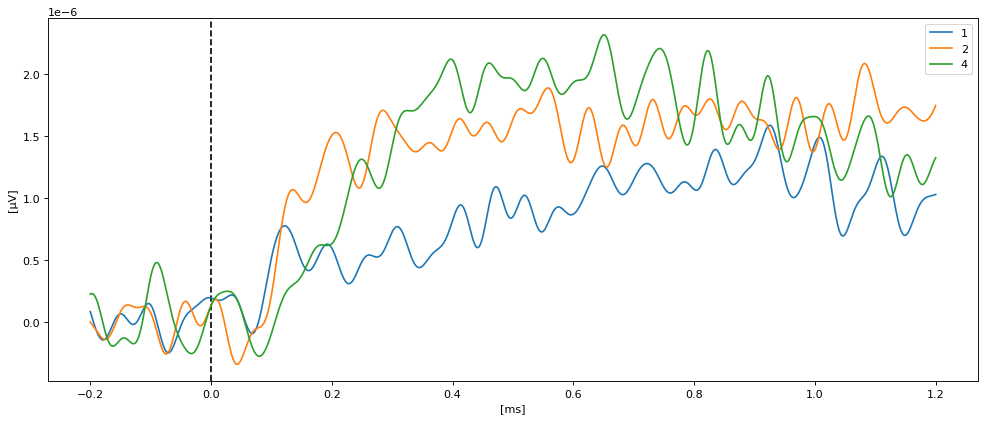

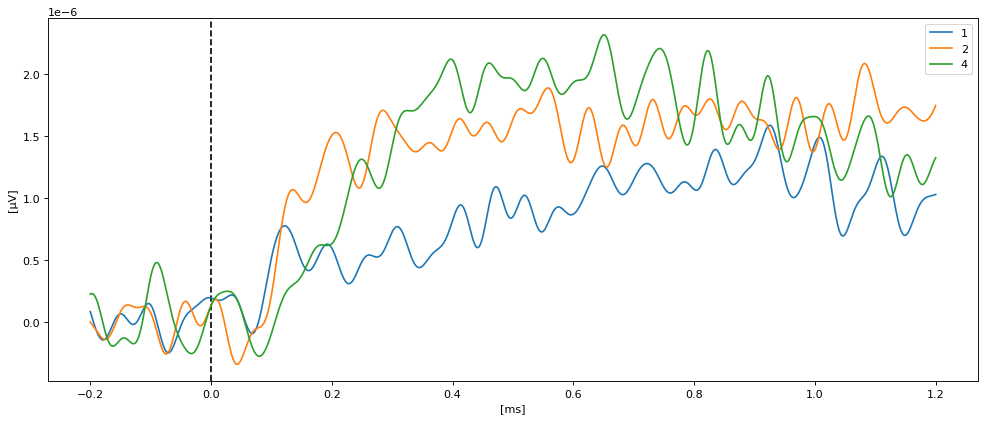

In [3]:
cda_dict = cda_dict1

cda_all = dict()

for cond in cda_dict[list(cda_dict.keys())[0]].keys():
    cda_all[cond] = dict()

    for f in cda_dict.keys():            
        if len(cda_dict[f][cond]['left']['good']) > 0:
            cda_dict_cur = (cda_dict[f][cond]['left']['good'] + cda_dict[f][cond]['right']['good'])/2
            
            cda_all[cond] = np.vstack([cda_all[cond], cda_dict_cur]) if len(cda_all[cond]) else cda_dict_cur
        else:
            print("==== SKIPPED: 0 points! (File: {} - Trigger: {})".format(str(f), str(t)))

plt.figure(figsize=(15, 6), dpi=80)
plt.axvline(x=0, color='k', linestyle='--')
plt.plot(times, cda_all['1'].mean(0), label='1')
plt.plot(times, cda_all['2'].mean(0), label='2')
plt.plot(times, cda_all['4'].mean(0), label='4')
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[ms]')
#plt.savefig("./img/Villena-Gonzalez-2019_CDA-reprod.jpg", dpi=300)

cda_dict = cda_dict2
cda_all_avg2 = dict()

for cond in cda_dict[list(cda_dict.keys())[0]].keys():
    cda_all_avg2[cond] = dict()

    for f in cda_dict.keys():            
        if len(cda_dict[f][cond]['left']['good']) > 0:
            cda_dict_cur = (cda_dict[f][cond]['left']['good'] + cda_dict[f][cond]['right']['good'])/2
            cda_all_avg2[cond] = np.vstack([cda_all_avg2[cond], cda_dict_cur]) if len(cda_all_avg2[cond]) else cda_dict_cur
        else:
            print("==== SKIPPED: 0 points! (File: {} - Trigger: {})".format(str(f), str(t)))

plt.figure(figsize=(15, 6), dpi=80)
plt.axvline(x=0, color='k', linestyle='--')
plt.plot(times, cda_all_avg2['1'].mean(0), label='1')
plt.plot(times, cda_all_avg2['2'].mean(0), label='2')
plt.plot(times, cda_all_avg2['4'].mean(0), label='4')
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[ms]')
#plt.savefig("./img/Villena-Gonzalez-2019_CDA-reprod.jpg", dpi=300)

# Weighted Average per Subject 'Contribution'. (i.e. Trial # Weigthed Average)

LS150419.bdf: [1] --> 16 right good, 16 left, good (weight: 0.04086845466155811)
DN250319.bdf: [1] --> 15 right good, 16 left, good (weight: 0.03959131545338442)
LF210119.bdf: [1] --> 16 right good, 15 left, good (weight: 0.03959131545338442)
FR070119.bdf: [1] --> 14 right good, 16 left, good (weight: 0.038314176245210725)
IP020519.bdf: [1] --> 15 right good, 16 left, good (weight: 0.03959131545338442)
LB020419.bdf: [1] --> 16 right good, 16 left, good (weight: 0.04086845466155811)
JH290119.bdf: [1] --> 16 right good, 15 left, good (weight: 0.03959131545338442)
RM280119.bdf: [1] --> 15 right good, 15 left, good (weight: 0.038314176245210725)
CS230419.bdf: [1] --> 16 right good, 15 left, good (weight: 0.03959131545338442)
VK030119.bdf: [1] --> 15 right good, 16 left, good (weight: 0.03959131545338442)
DS220119.bdf: [1] --> 16 right good, 14 left, good (weight: 0.038314176245210725)
DR210119.bdf: [1] --> 16 right good, 16 left, good (weight: 0.04086845466155811)
JC220119.bdf: [1] --> 16 

Text(0.5, 0, '[ms]')

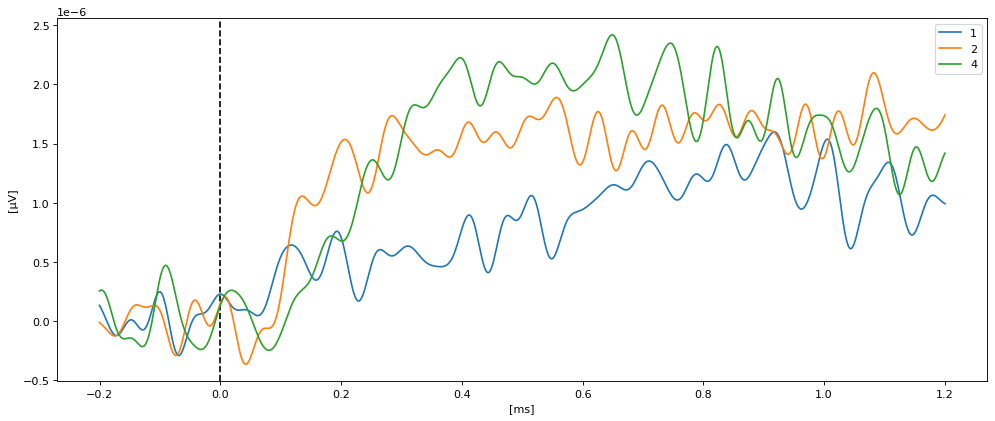

In [4]:
cda_dict = cda_dict1
cda_all_wavg = dict()

for cond in cda_dict[list(cda_dict.keys())[0]].keys():
    total_w_subject = 0
    cda_all_wavg[cond] = [0] * len(times)

    for f in cda_dict.keys():            
        if len(cda_dict[f][cond]['left']['good']) > 0:
            nb_right = int(report.at[f, '{}-right-good'.format(cond)])
            nb_left = int(report.at[f, '{}-left-good'.format(cond)])
            cda_dict_cur = cda_dict[f][cond]['left']['good'] * (nb_left/(nb_left + nb_right)) + cda_dict[f][cond]['right']['good'] * (nb_right/(nb_right+nb_left))
            w_subject = int(report.at[f, '{}-good'.format(cond)])/float(sum(report['{}-good'.format(cond)]))
            total_w_subject = total_w_subject + w_subject
            print('{}: [{}] --> {} right good, {} left, good (weight: {})'.format(f, cond, nb_right, nb_left, w_subject))
            cda_all_wavg[cond] = cda_all_wavg[cond] + (cda_dict_cur * w_subject)
        else:
            print("==== SKIPPED: 0 points! (File: {} - Trigger: {})".format(str(f), str(t)))
    
    print('Total weight: {}'.format(total_w_subject))
    print('-----------------------------------')
            
plt.figure(figsize=(15, 6), dpi=80)
plt.axvline(x=0, color='k', linestyle='--')
plt.plot(times, cda_all_wavg['1'], label='1')
plt.plot(times, cda_all_wavg['2'], label='2')
plt.plot(times, cda_all_wavg['4'], label='4')
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[ms]')
#plt.savefig("./img/Villena-Gonzalez-2019_CDA-reprod.jpg", dpi=300)


# Compare all Averages

Text(0.5, 0, '[ms]')

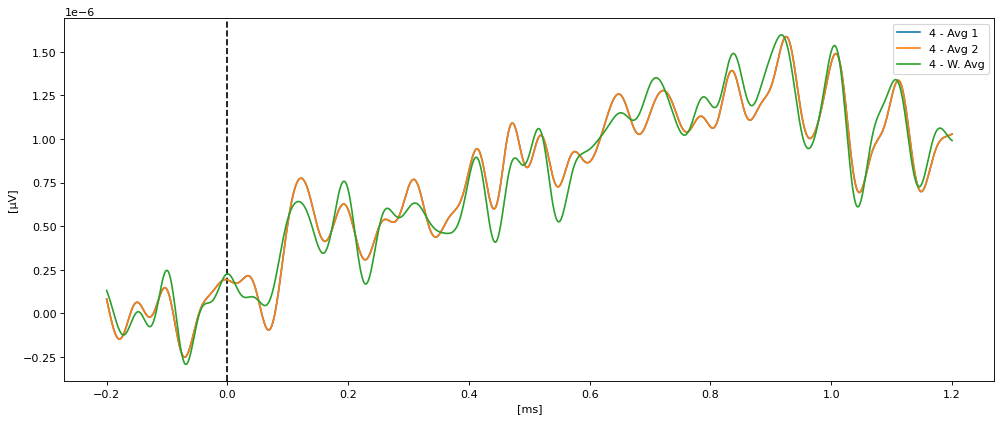

In [8]:
plt.figure(figsize=(15, 6), dpi=80)
plt.axvline(x=0, color='k', linestyle='--')
plt.plot(times, cda_all['1'].mean(0), label='4 - Avg 1')
plt.plot(times, cda_all_avg2['1'].mean(0), label='4 - Avg 2')
plt.plot(times, cda_all_wavg['1'], label='4 - W. Avg')
plt.legend()
plt.ylabel('[μV]')
plt.xlabel('[ms]')

# Playground Code

In [ ]:
# Method 2 - Ch Pairs average
cda2_per_epoch = np.array([])
cda2_per_chan = np.array([])

for i, chan in enumerate(chan_right):
    epochs_right = epochs_dict[cur_cond][cur_side][cur_perf].copy().pick_channels([chan_right[i]])
    epochs_left = epochs_dict[cur_cond][cur_side][cur_perf].copy().pick_channels([chan_left[i]])

    for i, e in enumerate(epochs_right):
        if cur_side == 'left':
            cda2_temp = epochs_right[i].get_data()[0][0] - epochs_left[i].get_data()[0][0]
        else:
            cda2_temp = epochs_left[i].get_data()[0][0] - epochs_right[i].get_data()[0][0]

        cda2_per_epoch = np.vstack([cda2_per_epoch, cda2_temp]) if len(cda2_per_epoch) else cda2_temp

    cda2_per_chan = np.vstack([cda2_per_chan, cda2_per_epoch.mean(0)]) if len(cda2_per_chan) else cda2_per_epoch.mean(0)
    
test_cda2 = cda2_per_chan.mean(0)
plt.plot(test_cda2)

In [ ]:
# ------------------------
# 5 -- CDA  --
# Hemisphere wise vs Ch Pairs wise
# ------------------------
cda_dict1[filename] = dict()
cda_dict2[filename] = dict()
for cur_cond in conds:
    cda_dict1[filename][cur_cond] = dict()
    cda_dict2[filename][cur_cond] = dict()
    for cur_side in sides:
        cda_dict1[filename][cur_cond][cur_side] = dict()
        cda_dict2[filename][cur_cond][cur_side] = dict()
        for cur_perf in perfs:
            if epochs_dict[cur_cond][cur_side][cur_perf] is not None:

                # Method 1 - Hemisphere average
                epochs_right = epochs_dict[cur_cond][cur_side][cur_perf].copy().pick_channels(chan_right)
                epochs_left = epochs_dict[cur_cond][cur_side][cur_perf].copy().pick_channels(chan_left)

                evoked_right = epochs_right.average()
                evoked_left = epochs_left.average()

                left = evoked_left.data.mean(0)
                right = evoked_right.data.mean(0)

                if cur_side == 'left':
                     cda_dict1[filename][cur_cond][cur_side][cur_perf] = left - right
                else:
                     cda_dict1[filename][cur_cond][cur_side][cur_perf] = right - left


                # Method 2 - Ch Pairs average
                cda2_per_epoch = np.array([])
                cda2_per_chan = np.array([])

                for i, chan in enumerate(chan_right):
                    epochs_right = epochs_dict[cur_cond][cur_side][cur_perf].copy().pick_channels([chan_right[i]])
                    epochs_left = epochs_dict[cur_cond][cur_side][cur_perf].copy().pick_channels([chan_left[i]])

                    for i, e in enumerate(epochs_right):
                        if cur_side == 'left':
                            cda2_temp = epochs_right[i].get_data()[0][0] - epochs_left[i].get_data()[0][0]
                        else:
                            cda2_temp = epochs_left[i].get_data()[0][0] - epochs_right[i].get_data()[0][0]

                        cda2_per_epoch = np.vstack([cda2_per_epoch, cda2_temp]) if len(cda2_per_epoch) else cda2_temp

                    cda2_per_chan = np.vstack([cda2_per_chan, cda2_per_epoch.mean(0)]) if len(cda2_per_chan) else cda2_per_epoch.mean(0)

                cda_dict2[filename][cur_cond][cur_side][cur_perf] = cda2_per_chan.mean(0)
                    

In [ ]:
epochs_right = epochs_dict[cur_cond][cur_side][cur_perf].copy().pick_channels([chan_right[1]])
epochs_left = epochs_dict[cur_cond][cur_side][cur_perf].copy().pick_channels([chan_left[1]])

data = epochs_right.get_data()
data

for i, e in enumerate(epochs_right):
    plt.plot(epochs_right[i].get_data()[0][0] - epochs_left[i].get_data()[0][0])
    